## Regresion Polinomial & Feature engineering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
import numpy as np

In [2]:
data = pd.read_csv('winequality-red.csv')

### Red Wine Quality Data

Se aplicará regresión para crear un modelo de la calidad de vino en función de características del mismo, siendo 1 el peor vino y 10 el mejor.

Variables de entrada:
1. fixed acidity 
2. volatile acidity 
3. citric acid 
4. residual sugar 
5. chlorides 
6. free sulfur dioxide 
7. total sulfur dioxide 
8. density 
9. pH 
10. sulphates 
11. alcohol 

Varaible a predecir: 
12. quality (puntuacion  entre 0 y 10) 



In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Instrucciones

1. Seleccionar y transformar(generando las combinaciones polinomiales para un polinomio de grado dos o tres a elección) las features que considere que son las mejores para predecir la calidad del vino, utilizar como minimo 2 features. Para seleccionar las features, hacer un analisis exploratorio por ejemplo(pero no limitado a ):  graficando y viendo la forma en que se comportan los datos.

 Por ejemplo, se tienen las features "a" y "b" y seleccionamos polinomio de grado 2, hacemos feature engineering para obtener :
 
 $[a,b,a^{2},b^{2},ab]$
 
 No olvidar el "bias" (parámetro multiplicado por 1) ,con lo cual el dataset puede quedar con las columnas:
 
 $[1,a,b,a^{2},b^{2},ab]$
2. Una vez transformada la data aplicar regresion lineal con las features polinomiales usando Tensorflow.

Requisitos adicionales:
* Se debe agregar al notebook un screenshot del grafo de tensorboard, simplificando(usando  names , y name_scope como visto en clase).

* Se debe generar un directorio de logs de tensorboard para cada corrida/experimento , con cada directorio identificando facilmente la configuración del experimento como visto en clase, por ejemplo para un experimento con learning rate = 0.1 , y polinomio grado 2  crear un directorio: lr=0.1_polinomio_grado=2. (Agregar al notebook un screenshot de estas gráficas)

* Concluir en markdown cual es el mejor modelo para este caso basado en la comparativa entre curvas de costo/error en tensorboard.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000243FCAD8080>,
      dtype=object)

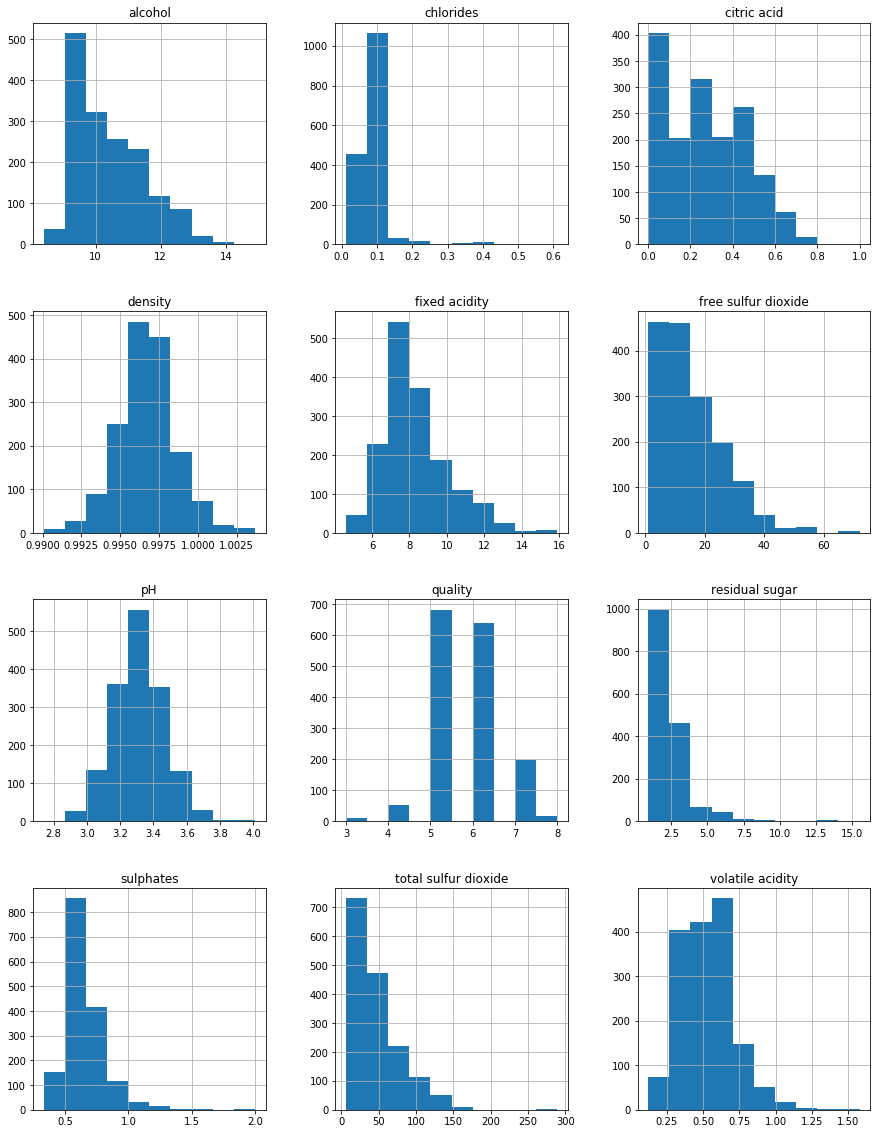

In [4]:
data.hist(figsize = (15,20))

In [5]:
data.corr().iloc[:,-1:]

,quality
fixed acidity,0.124052
volatile acidity,-0.390558
citric acid,0.226373
residual sugar,0.013732
chlorides,-0.128907
free sulfur dioxide,-0.050656
total sulfur dioxide,-0.185100
density,-0.174919
pH,-0.057731
sulphates,0.251397


Se seleccionan las variables a = alcohol y b = velocity acidity

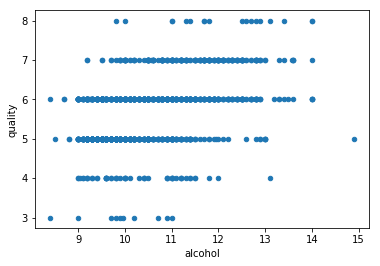

In [6]:
data.plot.scatter(x="alcohol",y="quality")

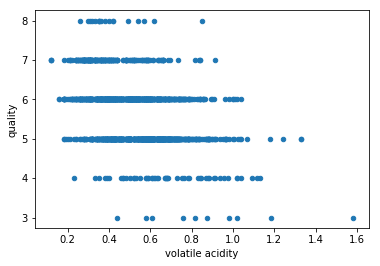

In [7]:
data.plot.scatter(x="volatile acidity",y="quality")

### Preparación de la data

In [147]:
n = len(data)
a = np.array(data["alcohol"]).reshape(n,1)
b = np.array(data["volatile acidity"]).reshape(n,1)
ab = np.multiply(a,b)
a2 = np.multiply(a,a)
b2 = np.multiply(b,b)
ones = np.ones(shape=[n,1])
#x = np.ndarray([[ones],[a],[b],[a2],[b2],[ab]])
x = np.concatenate([ones,a,b,a2,b2,ab],axis=1)
y = np.array(data["quality"]).reshape(n,1)

### Definición del grafo

In [148]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    X = tf.placeholder("float",[None,6],name="X") 
    Y = tf.placeholder("float",[None,1],name="Y") 
    learning_rate = tf.placeholder("float")
    W = tf.Variable(tf.zeros((6,1)), name = "W", dtype="float")
    b = tf.Variable(tf.zeros(1), name = "b", dtype="float")
    with tf.name_scope("model"):
        y_pred = tf.add(tf.matmul(X, W), b)
    with tf.name_scope("cost"):
        cost = tf.reduce_sum(tf.pow(y_pred-Y, 2)) / (2 * n)
        cost_summary = tf.summary.scalar("cost",cost)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()

### Tensorboard graph visual representation

<img src="./grafo.PNG">

In [149]:
def training(lr):
    tf.reset_default_graph()

    with tf.Session(graph=g) as sess: 

        writer = tf.summary.FileWriter('./graphs/lr='+str(lr)+"polinomio=2", sess.graph)
        sess.run(init) 
        for epoch in range(51): 

            sess.run(optimizer, feed_dict = {X : x, Y : y,learning_rate:lr}) 

            if (epoch + 1) % 10 == 0: 
                c,co,we,inte= sess.run([cost_summary,cost,W,b],feed_dict = {X : x, Y : y,learning_rate:lr}) 
                writer.add_summary(c, epoch+1)
                print("Epoch", (epoch + 1), ": cost =", co, "W =", we, "b =", inte) 
                
        writer.close()

In [150]:
training(0.01)

Epoch 10 : cost = inf W = [[-4.4394098e+17]
 [-4.7264003e+18]
 [-2.3100805e+17]
 [-5.0899507e+19]
 [-1.3470597e+17]
 [-2.4396959e+18]] b = [-4.4394095e+17]
Epoch 20 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]] b = [nan]
Epoch 30 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]] b = [nan]
Epoch 40 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]] b = [nan]
Epoch 50 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]] b = [nan]


In [151]:
training(0.001)

Epoch 10 : cost = 3.8006125e+22 W = [[-2.1196000e+07]
 [-2.2566245e+08]
 [-1.1029500e+07]
 [-2.4302024e+09]
 [-6.4315500e+06]
 [-1.1648350e+08]] b = [-21196002.]
Epoch 20 : cost = inf W = [[-1.0446655e+18]
 [-1.1121992e+19]
 [-5.4359972e+17]
 [-1.1977486e+20]
 [-3.1698522e+17]
 [-5.7410021e+18]] b = [-1.0446656e+18]
Epoch 30 : cost = inf W = [[-5.1487386e+28]
 [-5.4815851e+29]
 [-2.6791850e+28]
 [-5.9032216e+30]
 [-1.5622933e+28]
 [-2.8295105e+29]] b = [-5.1487376e+28]
Epoch 40 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]] b = [nan]
Epoch 50 : cost = nan W = [[nan]
 [nan]
 [nan]
 [nan]
 [nan]
 [nan]] b = [nan]


In [152]:
training(0.0001)

Epoch 10 : cost = 0.56122106 W = [[0.00059157]
 [0.00544883]
 [0.00029338]
 [0.04920911]
 [0.00015552]
 [0.00267512]] b = [0.00059157]
Epoch 20 : cost = 0.56030375 W = [[0.00075281]
 [0.00631755]
 [0.00036268]
 [0.04911054]
 [0.0001803 ]
 [0.00298441]] b = [0.00075281]
Epoch 30 : cost = 0.55939084 W = [[0.00091377]
 [0.00718477]
 [0.00043168]
 [0.04901211]
 [0.00020482]
 [0.00329128]] b = [0.00091377]
Epoch 40 : cost = 0.55848217 W = [[0.00107445]
 [0.0080505 ]
 [0.00050038]
 [0.04891395]
 [0.00022909]
 [0.00359576]] b = [0.00107445]
Epoch 50 : cost = 0.5575777 W = [[0.00123485]
 [0.00891476]
 [0.0005688 ]
 [0.04881605]
 [0.0002531 ]
 [0.00389786]] b = [0.00123485]


In [153]:
training(0.0001)

Epoch 10 : cost = 0.56122106 W = [[0.00059157]
 [0.00544883]
 [0.00029338]
 [0.04920911]
 [0.00015552]
 [0.00267512]] b = [0.00059157]
Epoch 20 : cost = 0.56030375 W = [[0.00075281]
 [0.00631755]
 [0.00036268]
 [0.04911054]
 [0.0001803 ]
 [0.00298441]] b = [0.00075281]
Epoch 30 : cost = 0.55939084 W = [[0.00091377]
 [0.00718477]
 [0.00043168]
 [0.04901211]
 [0.00020482]
 [0.00329128]] b = [0.00091377]
Epoch 40 : cost = 0.55848217 W = [[0.00107445]
 [0.0080505 ]
 [0.00050038]
 [0.04891395]
 [0.00022909]
 [0.00359576]] b = [0.00107445]
Epoch 50 : cost = 0.5575777 W = [[0.00123485]
 [0.00891476]
 [0.0005688 ]
 [0.04881605]
 [0.0002531 ]
 [0.00389786]] b = [0.00123485]


In [154]:
training(0.00001)

Epoch 10 : cost = 1.5895346 W = [[3.3601566e-04]
 [3.4923840e-03]
 [1.7340966e-04]
 [3.6662448e-02]
 [9.9567085e-05]
 [1.7890343e-03]] b = [0.00033602]
Epoch 20 : cost = 0.6294332 W = [[0.00043414]
 [0.0044521 ]
 [0.00022303]
 [0.04605028]
 [0.00012695]
 [0.00227073]] b = [0.00043414]
Epoch 30 : cost = 0.56629705 W = [[0.0004713 ]
 [0.00476278]
 [0.00024093]
 [0.04844866]
 [0.00013583]
 [0.00241738]] b = [0.0004713]
Epoch 40 : cost = 0.5620647 W = [[0.00049284]
 [0.00490712]
 [0.00025069]
 [0.04905592]
 [0.00013997]
 [0.00247816]] b = [0.00049284]
Epoch 50 : cost = 0.56170064 W = [[0.00051037]
 [0.00500883]
 [0.00025837]
 [0.04920417]
 [0.00014289]
 [0.00251691]] b = [0.00051037]


In [155]:
training(0.000001)

Epoch 10 : cost = 12.671777 W = [[5.3328487e-05]
 [5.5925985e-04]
 [2.7606084e-05]
 [5.9279986e-03]
 [1.5942564e-05]
 [2.8731395e-04]] b = [5.3328487e-05]
Epoch 20 : cost = 9.934642 W = [[1.00438905e-04]
 [1.05231931e-03]
 [5.19765235e-05]
 [1.11430744e-02]
 [2.99983440e-05]
 [5.40456094e-04]] b = [0.00010044]
Epoch 30 : cost = 7.816176 W = [[1.4207893e-04]
 [1.4871386e-03]
 [7.3500400e-05]
 [1.5730953e-02]
 [4.2394218e-05]
 [7.6353532e-04]] b = [0.00014208]
Epoch 40 : cost = 6.1765413 W = [[1.7890631e-04]
 [1.8707205e-03]
 [9.2519971e-05]
 [1.9767048e-02]
 [5.3329761e-05]
 [9.6016657e-04]] b = [0.00017891]
Epoch 50 : cost = 4.9075093 W = [[2.1149978e-04]
 [2.2092264e-03]
 [1.0933635e-04]
 [2.3317710e-02]
 [6.2980580e-05]
 [1.1335299e-03]] b = [0.0002115]


### Costos

<img src="./costos.PNG">

Con base a las gráficas es mejor learning rate es el de 1e-05